In [1]:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git
!pip install tensorflow==1.15.0
!pip install stable-baselines[mpi]==2.10.0
!pip install stockstats

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-sqgs5ytv
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-sqgs5ytv
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-_sqwhmsa/pyfolio_87d5cd98a5d14bd0821a7db9829e1237
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-_sqwhmsa/pyfolio_87d5cd98a5d14bd0821a7db9829e1237
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-_sqwhmsa/elegantrl_44c38157ee934c1c864341a07c77500c
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-_sqwhmsa/elegantrl_44c38157ee934c1c864341a07c77500c
     |████████████████████████████████| 73 kB 1.6 MB/s 
     |████████████████████████████████| 174 kB 42.2 MB/s 
     |████████████████████████████████| 57.6 MB 1.3 MB/s 
     |████████████████████████████████| 1.8 MB 20.8 MB/s 
     |██████

In [2]:
# fetch data from Yahoo Finance API
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader

from stable_baselines.common.vec_env import DummyVecEnv

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
import pathlib
import os
import copy

from stockstats import StockDataFrame as Sdf

import gym
from gym.utils import seeding
from gym import spaces

from stable_baselines import SAC
from stable_baselines import PPO2
from stable_baselines import A2C
from stable_baselines import DDPG
from stable_baselines import TD3
from stable_baselines.ddpg.policies import DDPGPolicy
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv

import datetime
import time

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Data importing and processing

In [3]:
def AddTurbulence(data):

    DataWithTurbulence = copy.deepcopy(data)

    PivotPrice = copy.copy(data).pivot(index="date", columns="tic", values="close").pct_change()
    DataUnic = copy.copy(data).date.unique()
    DataTurb = [0] * 252
    count = 0
    for date_id in range(252, len(DataUnic)):

        PriceCurrent = PivotPrice[PivotPrice.index == DataUnic[date_id]]
        PriceHist = PivotPrice[ (PivotPrice.index < DataUnic[date_id]) & (PivotPrice.index >= DataUnic[date_id - 252]) ]
        HistPriceFilt = PriceHist.iloc[PriceHist.isna().sum().min() : ].dropna(axis=1)
        TMP = (PriceCurrent[[x for x in HistPriceFilt]] - np.mean(HistPriceFilt, axis=0)).values.dot\
        (np.linalg.pinv(HistPriceFilt.cov())).dot((PriceCurrent[[x for x in HistPriceFilt]] - np.mean(HistPriceFilt, axis=0)).values.T)
        
        if TMP > 0:
            count += 1
            Turbtmp = TMP[0][0] if count > 2 else 0
        else:
            Turbtmp = 0
        
        DataTurb.append(Turbtmp)

    DataTurb = pd.DataFrame({"date": PivotPrice.index, "turbulence": DataTurb})
    DataWithTurbulence = DataWithTurbulence.merge(DataTurb, on="date")
    DataWithTurbulence = DataWithTurbulence.sort_values(["date", "tic"]).reset_index(drop=True)

    return DataWithTurbulence

def DataWithTechIndicators(df):
    """
    Args: data df
    Returns: data df with technical indicators
    """
    data = copy.deepcopy(df).sort_values(["tic", "date"])
    stock = Sdf.retype(copy.copy(data))

    for indic in ['macd', 'rsi_30', 'cci_30', 'dx_30']:
        indic_data = pd.DataFrame()
        for tic_id in range(len(stock.tic.unique())):
                indic_tmp = pd.DataFrame(stock[stock.tic == stock.tic.unique()[tic_id]][indic])
                indic_tmp["tic"], indic_tmp["date"] = stock.tic.unique()[tic_id], list(data[data.tic == stock.tic.unique()[tic_id]]["date"])
                indic_data = indic_data.append(indic_tmp, ignore_index=True)

        data = data.merge(indic_data[["tic", "date", indic]], on=["tic", "date"], how="left")
    data.sort_values(["date", "tic"], inplace=True)
    return data

def PreProcess(data):
    ProcessedData = DataWithTechIndicators(data)

    ProcessedData = AddTurbulence(ProcessedData)

    ProcessedData.fillna(method='ffill', inplace=True)
    ProcessedData.fillna(method='bfill', inplace=True)
    return ProcessedData


In [4]:
dow_30 = ['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']
data = YahooDownloader(start_date = '2009-01-01', end_date = '2021-11-01', ticker_list = dow_30).fetch_data()

data = PreProcess(data)
data['date'] = pd.to_datetime(data['date'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### Environment setup

In [ ]:
class Env(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, start_day):
        # initialization
        self.shares_per_trade = 100
        self.initial_balance = 1000000
        self.dimension_stock = 30
        self.transac_fee = 0.001
        self.reward_scaling = 1e-4

        self.initial_day = start_day
        self.day = start_day
        self.df = df
        self.action_space = spaces.Box(low = -1, high = 1,shape = (self.dimension_stock,))
        self.terminal = False

        self.state = [self.initial_balance] + [0]*self.dimension_stock + list(self.df.close.iloc[self.day]) + self.ConcatMacdRsiCciAdx(self.day)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (len(self.state),))
        self.reward = 0
        self.cost = 0
        self.asset_memory = [self.initial_balance]
        self.rewards_memory = []
        self.portfolio_value_memory = []
        self.trades = 0
        self.sharpe = 0
        self._seed()

    def ConcatMacdRsiCciAdx(self, i):
        return sum([list(self.df[tech].iloc[i]) for tech in ['macd', 'rsi_30', 'cci_30', 'dx_30']], [], )

    def calculate_assets(self):
        return self.state[0] + sum([self.state[1+i] * self.state[1+i+self.dimension_stock] for i in range(self.dimension_stock)])

    def sell_batch(self, actions):
        shares = np.array(self.state[1 : self.dimension_stock+1])
        prices = np.array(self.state[self.dimension_stock+1 : self.dimension_stock*2+1])
        actions = np.where(actions<0, -actions, 0)
        qty = np.minimum(actions, shares)

        self.state[0] += np.sum(prices * qty * (1 - self.transac_fee))
        for i, q in enumerate(qty):
            self.state[i+1] -= q
        self.cost += prices * qty * self.transac_fee
        self.trades += 1

    def buy_stock(self, index, action):
        price = self.state[index+self.dimension_stock+1]
        qty = min(action, self.state[0] // (price * (1+self.transac_fee)))
        self.state[index + 1] += qty
        self.state[0] -= (1 + self.transac_fee) * price * qty
        self.cost += self.transac_fee * price * qty
        self.trades += 1
        
    def run_trades(self, actions):
        actions = actions * self.shares_per_trade
        self.sell_batch(actions)
        
        ### Consider weighing with price or taking smallest first
        actions_sorted = np.argsort(actions)
        for idx in actions_sorted[::-1][:(actions>0).sum()]: 
            self.buy_stock(idx, actions[idx])

    def terminalStep(self):
        return self.state, self.reward, self.terminal, {"total_assets":self.calculate_assets()}

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1


        if self.terminal:
            return self.terminalStep()

        begin_total_asset = self.calculate_assets()
        self.run_trades(actions)

        self.day += 1
        self.state =  self.state[:self.dimension_stock+1] + list(self.df.close.iloc[self.day]) + self.ConcatMacdRsiCciAdx(self.day)

        end_total_asset = self.calculate_assets()
        self.asset_memory.append(end_total_asset)
        self.reward = end_total_asset - begin_total_asset            
        self.rewards_memory.append(self.reward)
        self.reward = self.reward*self.reward_scaling

        self.portfolio_value_memory.append(end_total_asset)# Memorizes the portfolio's value at each step for cumulative return 

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_balance]
        self.day = self.initial_day
        self.cost = 0
        self.trades = 0
        self.terminal = False
        self.rewards_memory = []
        self.state = [self.initial_balance] + [0]*self.dimension_stock + list(self.df.close.iloc[self.day]) + self.ConcatMacdRsiCciAdx(self.day)
        return self.state
    
    def render(self, mode='human', close=False):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [ ]:
class Env_train(Env):
    def __init__(self, df, start_day=0):
        super().__init__(df, start_day)

    def terminalStep(self):
        df_total_value = pd.DataFrame(self.asset_memory)
        df_total_value.columns = ['account_value']
        df_total_value['daily_return']=df_total_value.pct_change(1)
        sharpe = (252**0.5)*df_total_value['daily_return'].mean()/df_total_value['daily_return'].std()
        self.sharpe = sharpe
        
        return self.state, self.reward, self.terminal, {"sharpe": sharpe, "total_assets": self.calculate_assets()}

In [ ]:
class Env_valid(Env):
    def __init__(self, df, start_day=0, turbulence_threshold=140, iteration=''):
        super().__init__(df, start_day)

        self.turbulence_threshold = turbulence_threshold
        self.turbulence = 0        
        self.iteration=iteration

    def run_trades(self, actions):
        if self.turbulence >= self.turbulence_threshold:
            actions = -1*np.array(self.state[1 : self.dimension_stock+1])
        self.turbulence = self.df['turbulence'].iloc[self.day]

        super().run_trades(actions)

    def terminalStep(self):
        df_total_value = pd.DataFrame(self.asset_memory)
        df_total_value.columns = ['account_value']
        df_total_value['daily_return']=df_total_value.pct_change(1)
        sharpe = (4**0.5)*df_total_value['daily_return'].mean()/df_total_value['daily_return'].std()
        self.sharpe = sharpe
        
        return self.state, self.reward, self.terminal, {"sharpe": sharpe, "total_assets": self.calculate_assets()}

    def reset(self):
        self.turbulence = 0
        return super().reset()

In [158]:
class Env_trade(Env):
    def __init__(self, df, start_day=0, turbulence_threshold=140, initial=True, previous_state=[], model_name='', iteration=''):
        super().__init__(df, start_day)

        self.turbulence_threshold = turbulence_threshold
        self.turbulence = 0
        self.iteration = iteration
        self.model_name = model_name
        self.initial = initial
        self.previous_state = previous_state

    def run_trades(self, actions):
        if self.turbulence >= self.turbulence_threshold:
            actions = -1*np.array(self.state[1 : self.dimension_stock+1])
        self.turbulence = self.df['turbulence'].values[self.day]

        super().run_trades(actions)

    def terminalStep(self): #step, terminal: plot self.asset_memory
        df_total_value = pd.DataFrame(self.asset_memory)
        df_total_value.columns = ['account_value']
        df_total_value['daily_return']=df_total_value.pct_change(1)
        sharpe = (4**0.5)*df_total_value['daily_return'].mean()/df_total_value['daily_return'].std()
        self.sharpe = sharpe
        
        return self.state, self.reward, self.terminal, {"sharpe": sharpe, "total_assets": self.calculate_assets()}

    def reset(self):
        if self.initial or len(self.previous_state)==0:
            self.portfolio_value_memory.append(self.initial_balance)
            self.turbulence = 0
            return super().reset()

        self.turbulence = 0
        previous_total_asset = self.previous_state[0] + \
            sum([self.previous_state[1+i] * self.previous_state[1+i+self.dimension_stock] for i in range(self.dimension_stock)])
        self.asset_memory = [previous_total_asset]
        self.day = self.initial_day
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        self.state = self.previous_state[:self.dimension_stock+1] + list(self.df.close.iloc[self.day]) + self.ConcatMacdRsiCciAdx(self.day)

        self.portfolio_value_memory.append(self.calculate_assets())
        return self.state

### Added all agents specified in the paper

In [159]:
def get_agent(agent_name):
    if agent_name == 'A2C': return A2C
    if agent_name == 'DDPG': return DDPG
    if agent_name == 'PPO': return PPO2

def initialize_agent(agent_name, env):
    agent = get_agent(agent_name)
    model = agent('MlpPolicy', env)
    return model

def train_agent(model, model_name, timesteps):
    start = time.time()
    model.learn(total_timesteps=timesteps)
    #model.save(f"{config.TRAINED_MODEL_DIR}/{model_name}")
    end = time.time()    
    return model

def DRL_validation(model, test_data, test_env, test_obs):
    """make a prediction"""
    start = time.time()
    for i in range(len(test_data.index.unique())):
        action, _states = model.predict(test_obs)
        test_obs, rewards, dones, info = test_env.step(action)
    end = time.time()


def DRL_prediction(model, name, last_state, unique_date, env_trade):
    ### make a prediction based on trained model###
    obs_trade = env_trade.reset()

    for i in range(len(unique_date)):
        action, _states = model.predict(obs_trade)
        obs_trade, rewards, dones, info = env_trade.step(action)
        if i == (len(unique_date) - 1):
            last_state = env_trade.render()

    # df_last_state = pd.DataFrame({'last_state': last_state})
    # df_last_state.to_csv('results/last_state_{}_{}.csv'.format(name, i), index=False)
    return last_state


### Added ensemble strat

In [160]:
import matplotlib.pyplot as plt
import matplotlib.dates as pltdates

def plot_graph(dates, values, title="This is a cute graph"):
    dates = pltdates.date2num(dates)
    plt.plot_date(dates[:len(values)], values)
    plt.show()

In [161]:
def data_split(df,start,end):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(start <= df.date) & (df.date < end)]
    data = data.sort_values(['date'], ignore_index=True)
    #data  = data[final_columns]
    data.index = data.date.factorize()[0]
    return data

In [168]:
def run_ensemble_strategy(df, unique_trade_date, rebalance_window, validation_window) -> None:
    """Ensemble Strategy that combines PPO, A2C and DDPG"""
    print("============Start Ensemble Strategy============")
    # for ensemble model, it's necessary to feed the last state
    # of the previous model to the current model as the initial state
    last_state_ensemble = []

    # Regrouping data by date
    df = df.groupby('date').agg({'close': list, 'macd': list, 'rsi_30': list, 'cci_30': list, 'dx_30': list, 'turbulence': 'max'})
    df.reset_index(level=0, inplace=True)
    
    ### ======================= Splitting data between train, val and test ======================= ###
    # We match the paper's timestamps
    d1 = datetime.datetime(2009, 1, 1) # DATE
    d2 = datetime.datetime(2015, 10, 1) # DATE
    d3 = datetime.datetime(2016, 1, 1) # DATE
    d4 = datetime.datetime(2020, 5, 8) # DATE

    ## We then proceed to split the dataset:
    # Train
    train = data_split(df, d1, d2)
    unique_train_date = train.date.unique()

    # Validation
    valid = data_split(df, d2, d3)
    unique_valid_date = valid.date.unique()

    # Trade
    trade = data_split(df, d3, d4)#timedelta(2) because of split does not take last date
    unique_trade_date = trade.date.unique()

    ### ======================= Initialize agents and their environments ======================= ###
    agent_names   = ['A2C', 'PPO', 'DDPG']    

    # Train
    training_envs = [Env_train(train) for name in agent_names]
    models        = []
    for env, name in zip(training_envs, agent_names):
        model = initialize_agent(name, env)
        models.append(model)

    # Validation
    valid_envs = [Env_valid(valid) for name in agent_names]

    ### =======================        Training and Validation Phase     ======================= ###
    model_names = ['A2C_30k_dow', 'PPO_100k_dow', 'DDPG_10k_dow']
    timesteps = [30000, 100000, 10000]
    sharpes = []

    print("======Training has started from: ", d1, "to ", d2)
    for model, model_name, training_env, valid_env, timestep in zip(models, model_names, training_envs, valid_envs, timesteps):
        training_env.reset()
        obs_val = valid_env.reset()

        model = train_agent(model, model_name, timestep) 
        DRL_validation(model=model, test_data=valid, test_env=valid_env, test_obs=obs_val)
        sharpe = valid_env.sharpe

        sharpes.append(sharpe) 
        print("   ", model_name + " Sharpe Ratio: ", sharpe)
    print("============Training Done============")

    ### =======================               Trading Phase              ======================= ###
    model_ensemble         = None
    last_state_ensemble    = [] # We started trading, therefore the last state is empty (It will be initialized in trade_env)
    portfolio_value_memory = np.array([]) #Remembers the portfolio's value for ensemble strategy, useful to compute cumulative return
    model_use              = []
    for iter_num in range(0, len(unique_trade_date), rebalance_window):
        ## Choosing best model
        sharpe_a2c, sharpe_ppo, sharpe_ddpg = sharpes
        model_a2c, model_ppo, model_ddpg    = models

        # Model Selection based on sharpe ratio
        if (sharpe_ppo >= sharpe_a2c) & (sharpe_ppo >= sharpe_ddpg):
            model_ensemble = model_ppo
            model_use.append('PPO')
        elif sharpe_a2c >= sharpe_ddpg:
            model_ensemble = model_a2c
            model_use.append('A2C')
        else:
            model_ensemble = model_ddpg
            model_use.append('DDPG')
        
        # Trading with the chosen model
        start_date, end_date = unique_trade_date[iter_num], unique_trade_date[min(iter_num + rebalance_window, len(unique_trade_date)-1)]
        trade_i              = data_split(df, start=start_date, end=end_date)
        trade_env            = Env_trade(trade_i, initial=False, previous_state=last_state_ensemble)
        print("======Trading from: ", start_date, "to ", end_date)
        print("   Used Model: ", model_use[-1])
        print("   Portfolio's liquid asses: ", int(last_state_ensemble[0]) if last_state_ensemble != [] else 1e6)
        last_state_ensemble  = DRL_prediction(model=model_ensemble, 
                                              name="ensemble", 
                                              last_state=last_state_ensemble, 
                                              unique_date=trade_i.date.unique(), 
                                              env_trade=trade_env)
        portfolio_value_memory = np.append(portfolio_value_memory, np.array(trade_env.portfolio_value_memory))
        print("      Ensemble model Sharpe Ratio: ", sharpe)
        print("============Trading Done============")
        
        ## Running all three models on same timeframe in order to chose the next ensemble model
        # Initializing trade env for each nodel with 3 month worth of data
        valid_envs_i           = [Env_valid(trade_i) for name in model_names]
        sharpes                = []
        print("======Evaluating all three models: ")
        for model, model_name, valid_env in zip(models, model_names, valid_envs_i):
            obs_val = valid_env.reset()

            DRL_validation(model=model, test_data=valid, test_env=valid_env, test_obs=obs_val)
            sharpe = valid_env.sharpe

            sharpes.append(sharpe) 
            print("      ", model_name + " Sharpe Ratio: ", sharpe)
        print("======Evaluation Done")

    ## Adding last value to portfolio's value

    ## Computing cumulative reward of ensemble strategy in the time frame d3 to d4
    initial_value          = trade_env.initial_balance
    portfolio_value_memory = portfolio_value_memory.reshape(-1)
    cumulative_return      = (portfolio_value_memory - initial_value) / initial_value

    plot_graph(unique_trade_date, cumulative_return, title="Cumulative return for ensemble strategy")    

    return cumulative_return, model_use

##### Converting dates to date time format

============Start Ensemble Strategy============
======Training has started from:  2009-01-01 00:00:00 to  2015-10-01 00:00:00
    A2C_30k_dow Sharpe Ratio:  -0.0906022733951636
    PPO_100k_dow Sharpe Ratio:  0.052641807088784597
    DDPG_10k_dow Sharpe Ratio:  0.07962904027021739
============Training Done============
======Trading from:  2016-01-04T00:00:00.000000000 to  2016-04-05T00:00:00.000000000
   Used Model:  DDPG
   Portfolio's value:  1000000.0
      Ensemble model Sharpe Ratio:  0.07962904027021739
============Trading Done============
======Evaluating all three models: 
       A2C_30k_dow Sharpe Ratio:  0.14643154222266555
       PPO_100k_dow Sharpe Ratio:  0.24839716825732105
       DDPG_10k_dow Sharpe Ratio:  0.046572800021975315
======Evaluation Done
======Trading from:  2016-04-05T00:00:00.000000000 to  2016-07-05T00:00:00.000000000
   Used Model:  PPO
   Portfolio's value:  1000000
      Ensemble model Sharpe Ratio:  0.046572800021975315
============Trading Done========

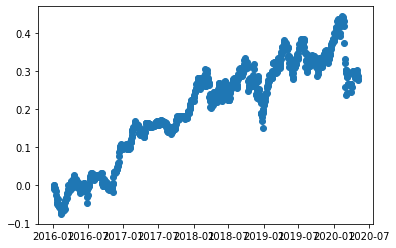

(array([ 0.        ,  0.        , -0.00061593, ...,  0.27621199,
         0.28023243,  0.28666916]),
 ['DDPG',
  'PPO',
  'A2C',
  'DDPG',
  'DDPG',
  'PPO',
  'DDPG',
  'A2C',
  'A2C',
  'DDPG',
  'PPO',
  'DDPG',
  'DDPG',
  'DDPG',
  'PPO',
  'DDPG',
  'DDPG',
  'PPO'])

In [169]:
# rebalance_window is the number of months to retrain the model
# validation_window is the number of months to validation the model and select for trading
rebalance_window = 63
validation_window = 63
unique_trade_date = data.date.unique()
## Ensemble Strategy
run_ensemble_strategy(df=data, 
                      unique_trade_date = unique_trade_date,
                      rebalance_window = rebalance_window,
                      validation_window = validation_window)